[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/092_ml_svm/092_ml_svm.ipynb)

# ML - Support Vector Machine

En posts anteriores hemos aprendido sobre las dos tareas más típicas en el mundo del *Machine Learning*: la regresión y la classificación, y un primer modelo sencillo para atacar estos problemas: la regresión lineal (o regresión logísitica en el caso de la clasificación). Si bien este modelo es muy sencillo, eficiente y explicable (cada variable tiene un peso asignado, por lo que podemos saber cuánto contribuye a la decisión final) su principal limitación se encuentra, como ya vimos, en que no es capaz de aprender datasets que no sigan tendencias lineales. Esto motivó el desarrollo de nuevos modelos de ML capaces de sobreponerse a estas limitaciones. Entre ellos, uno de los más usados por sus buenas prestaciones cuando no disponemos de muchos datos son las máquinas de soporte vectorial, o *Support Vector Machines* (SVM) en inglés.

## Clasificación lineal con SVMs

Mientras que los modelos de regresión lineal se basan en la idea de minimizar el número de errores, las SVMs intentan maximizar la distancia entre las fronteras de decisión y los datos de entrenamiento: el margen.


![svm](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/300px-SVM_margin.png)

Añadir más datos fuera del margen no afecta al modelo ya que está totalmente determinado por las instancias localizadas en los límites de la frontera: los vectores soporte. Esto solo funciona si los datos son linealmente separables, en caso contrario deberemos aceptar un cierto número de errores (aunque en la sección siguiente veremos como hacerlo con un modelo no lineal).

En *Scikit-Learn* puedes usar el modelo [LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html) para entrenar un clasificador lineal con SVMs. En el siguiente ejemplo veremos como podemos ajustar el número de errores aceptables en la clasificación (instancias dentro del margen) con el dataset Iris, que ya hemos usado en varios de los posts anteriores.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

# cargar dataset (usamos dos features y una sola clase)
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

# normalizar datos 
scaler = StandardScaler()

# SVMs (dos diferentes valires de C)
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

# entrenar modelos
scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/home/juan/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [3]:
# extraer fronteras de decisión (desnormalizadas)
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Calcular vectores soporte
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

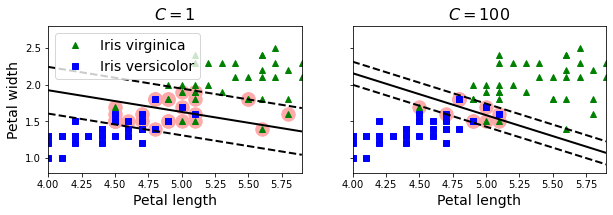

In [4]:
# visualizar fronteras de decisión
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.show()

Para saber si una instancia $\bf{x}$ pertenece a una clase u otra, podemos calcular la frontera de decición $\mathbf{w}^T \mathbf{x} + b = w_1 x_1 + w_2 x_2 + ... + w_n x_n + b$, donde $\bf{w}$ son los parámteros del modelo, y $b$ es el *bias*. Luego, podemos asignar la clase en función de 

\begin{equation}
\hat{y} = \left\{
  \begin{array}{lcr}
  0 & \textrm{si} & \mathbf{w}^T \mathbf{x} + b < 0\\
  1 & \textrm{si} &  \mathbf{w}^T \mathbf{x} + b \geq 0
  \end{array} \right.
\end{equation}

Entrenar uns SVM lineal consiste en encontrar los valores de $\bf{w}$ y $b$ que mazimicen el margen a la vez que minimicen el número de errores. Asumiendo que no queremos ningún error, necesitamos que la frontera de decisión sea mayor que 1 para todas las muestras de la clase positiva y menor que -1 para las muestras negativas. Esto puede expresarse como $t^{(i)}(\mathbf{w}^T \mathbf{x} + b)\geq 1$ donde $t^{(i)}=-1$ para las muestras negativas y $t^{(i)}=1$ para las muestras positivas. Para permitir errores, se puede añadir la *slack variable*, y el hyperparámetro $C$ para ajustar el número de errores admisibles. El problema se formaliza de la manera siguiente:

\begin{equation}
  \begin{array}{ll}
    \underset{\mathbf{w},b,\zeta}{\textrm{minimize}} & \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \sum_{j=1}^N \zeta^{(j)}  \\
    \textrm{subject to} & t^{(j)}(\mathbf{w}^T \mathbf{x}^{(j)} + b)\geq 1 - \zeta^{(j)} & \textrm{and} & \zeta^{(j)} \geq 0 & \textrm{for} & i = 1, 2, ..., N
  \end{array}
\end{equation}

El cual tiene la forma de problema de optimización cuadrática con resticciones lineales, cuya solución puede encontrarse mediante programación cuadrática, o *Quadratic Programming* (QP) en inglés. Aún así, las SVM cumplen las condiciones para resolver el problema en la forma dual, *dual form* en inglés, lo cual permite encontrar soluciones más rápidas usando y también permiten el uso del *kernel trick* (que veremos más adelante).

\begin{equation}
  \begin{array}{l}
    \underset{\alpha}{\textrm{minimize}} & \frac{1}{2} \sum_{i=1}^N \sum_{j=1}^N \alpha^{(i)}\alpha^{(j)}t^{(i)}t^{(j)}\mathbf{x}^{(i)T}\mathbf{x}^{(j)} - \sum_{i=1}^N \alpha^{(i)} \\
    \textrm{subject to} & \alpha^{(i)} \geq 0 \ \ \textrm{for} \ \ i = 1, 2, ..., N
  \end{array}
\end{equation}

Donde el vector $\hat{\mathbf{\alpha}}$ minimiza la equation (usando un solver QP) y los prámetros de la SVM pueden calcularse como:

\begin{equation}
  \begin{array}{l}
    \hat{\mathbf{w}} = \sum_{j=1}^N \hat{\alpha}^{(j)} t^{(j)} \mathbf{x}^{(j)} \\
    \hat{b} = \frac{1}{N} \sum_{j=1, \hat{\alpha}^{(j)} > 0}^N (t^{(j)} - \hat{\mathbf{w}}^T \mathbf{x}^{(j)})
  \end{array}
\end{equation}

Visto esto, te recomiendo usar la implementación de *Scikit-Learn* en la que tienes ya todo implementado para ahorrarte más dolores de cabeza 😝

## Clasiciación no lineal con SVMs

Como comentaba al principio del post, una de las ventajas principales de las SVMs con respecto a los modelos lineales es que son capaces de representar no-linealidades. Para ello, los datos son reproyectados a una nueva representación de mayor dimensión en la cual la frontera de decisión expresarse como un hyperplano, el cuál maximiza la distancia entre él mismo y los puntos más cercanos de cada clase (los vectores soporte). 

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/linear_ploy.png)

Si bien podemos seguir haciendo *feature engineering* para calcular nosotros mismos la reproyección

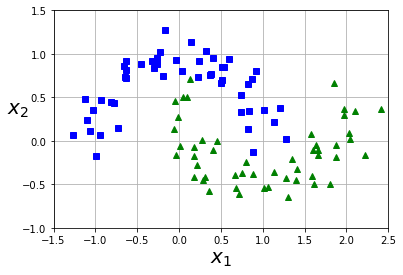

In [5]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

/home/juan/miniconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

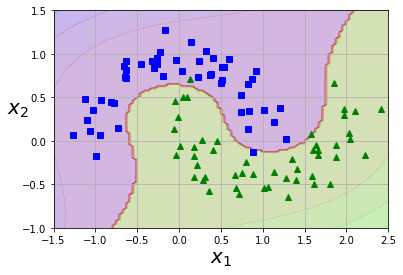

In [7]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

plt.show()

Las SVMs permiten incluir esta reproyección directamante en el modelo. Esta técnica de reproyección se conoce como el *kernel trick*. Para ello podemos usar el modelo [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html).

In [8]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [9]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

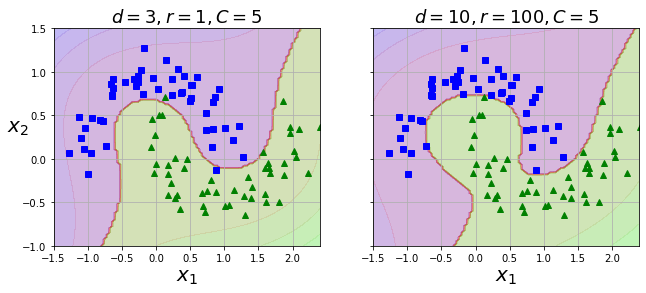

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

plt.show()

Sin embargo, el *kernel trick* más usado consiste calcular features adicionales usando funciones de similitud. Entre ellas, la función *RBF* (*Gaussian Radial Basis Function*) es una de las más comunes.


\begin{equation}
  \phi_\gamma(\mathbf{x}, l) = e^{-\gamma || \mathbf{x}-l||^2}
\end{equation}

Usando las instancias en $x_1=-2$ y $x_1 = 1$ con $\gamma = 0.3$.

![](https://mymlpics.s3.eu-de.cloud-object-storage.appdomain.cloud/svm_kernel_gauss.png)

En el caso límite, podemos usar todas las instancias del dataset para asegurarnos que los datos son linealmente separables, pero con tantas features como muestras.

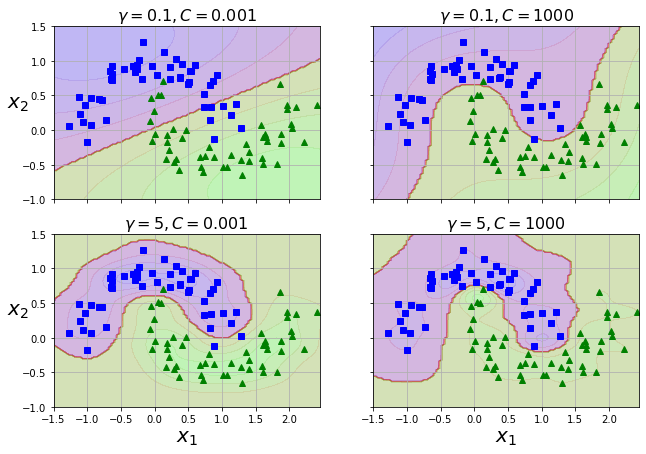

In [11]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

plt.show()

Existen otros kernels, aunque no son muy comunes.

\begin{equation}
  \begin{array}{rl}
    \textrm{Linear}: & K(\mathbf{a},\mathbf{b}) = \mathbf{a}^T \mathbf{b} \\
    \textrm{Plynomial}: & K(\mathbf{a},\mathbf{b}) = (\gamma \mathbf{a}^T \mathbf{b} + r)^d \\
    \textrm{Gaussina RBF}: & K(\mathbf{a},\mathbf{b}) = exp
    (-\gamma || \mathbf{a} - \mathbf{b} ||^2) \\
    \textrm{Sigmoid}: & K(\mathbf{a},\mathbf{b}) = \textrm{tanh} (\gamma \mathbf{a}^T \mathbf{b} + r)\\
  \end{array}
\end{equation}

Para poder usar un kernel, éste debe cumplir unos requisitos. En el caso de una transormación polinomial de segundo grado:

\begin{equation}
  \phi(\mathbf{x}) = \phi \left( \left(
    \begin{array}{c}
      x_1 \\ x_2
     \end{array} \right) \right) = \left(
       \begin{array}{c}
      x_1^2 \\ \sqrt{2} x_1 x_2 \\ x_2^2
     \end{array} \right)
\end{equation}

Si aplicamos la transformación a dos vectores y claculamos su producto

\begin{equation}
  \phi(\mathbf{a})^T \phi(\mathbf{b}) = \left(
       \begin{array}{c}
      a_1^2 \\ \sqrt{2} a_1 a_2 \\ a_2^2
     \end{array} \right)^T \left(
       \begin{array}{c}
      b_1^2 \\ \sqrt{2} b_1 b_2 \\ b_2^2
     \end{array} \right) = 
     a_1^2 b_1^2 + 2 a_1 b_1 a_2 b_2 + a_2^2 b_2^2 = 
     (a_1 b_1 + a_2 b_2)^2 = \left( \left(
       \begin{array}{c}
      a_1 \\ a_2
     \end{array} \right)^T \left(
       \begin{array}{c}
      b_1 \\ b_2
     \end{array} \right) \right)^2 = 
     (\mathbf{a}^T \mathbf{b})^2
\end{equation}

Como vemos, el producto de dos vectores transformados es igual al producto de los vectores originales elevados al cuadrado, $\phi(\mathbf{a})^T \phi(\mathbf{b}) =(\mathbf{a}^T \mathbf{b})^2$. Esto permite aplicar el *kernel trick* a todo el dataset sin la necesidad de calcular las transformaciones, lo cual permite resolver el problema de manera eficiente. Para que funcione, la transformación tiene que ser un *kernel*, como las funciones vistas anteriormente.

Finalmente, para obtener predicciones

\begin{equation}
  h_{\hat{\mathbf{w}},\hat{b}} ( \phi(\mathbf{x}^{(n)})) = \sum_{j=1, \hat{\alpha}^{(j)} > 0}^N \hat{\alpha}^{(j)} t^{(j)} K(\mathbf{x}^{(j)}, \mathbf{x}^{(n)}) + \hat{b}
\end{equation}

donde $\hat{b} = 1/N \sum_{i=1, \hat{\alpha}^{(i)} > 0}^N (t^{(i)} - \sum_{j=1, \hat{\alpha}^{(j)} > 0}^N \hat{\alpha}^{(j)} t^{(j)} K(\mathbf{x}^{(i)},\mathbf{x}^{(j)}))$. Para poder hacer predicciones simplemente tenemos que calcular el producto de las nuevas instancias con los vectores soporte ($\alpha^{(j)} \neq 0$).

## Regresión con SVMs

Además de clasificación, las SVMs también permiten resolver problemas de regresión. Para ello, simplemente tenemos que invertir la función objetivo y en vez de maximizar el margen entre vectores soporte, intentaremos incluir tantas muestras como sea posible en él. Para ello puedes usar el modelo [LinearSVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html?highlight=linearsvr#sklearn.svm.LinearSVR) de *Scikit-Learn*.

In [12]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [13]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [14]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

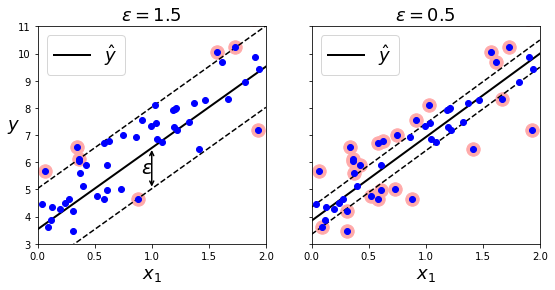

In [15]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
plt.show()

Añadir más muestras dentro del margen no afectará al resultado. También podemos aplicar el *kernel trick* si tenemos datos no lineales. Para ello puedes usar el modelo [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html?highlight=svr#sklearn.svm.SVR).

In [16]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [17]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

In [18]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

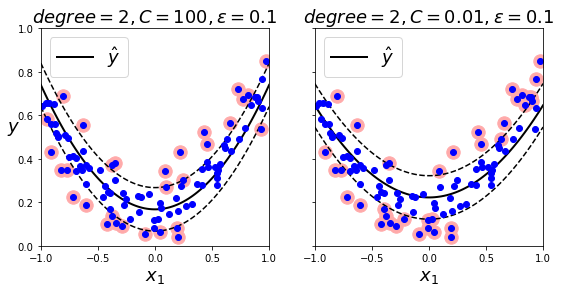

In [19]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
plt.show()

Como ya hemos comentado en posts anteriores, la mejor combinación de hyperparámetros la tendrás que encontrar usando técnicas de optimización de hyperparámetros (*grid search*, *random search*, etc).

## Descenso por Gradiente

Si bien las SVMs nos permite trabajar con datos no lineales, una mejora con respecto a los modelos lineales, éstos tienen la principal limitación de que necesitan que todo el dataset esté cargado en memoria. Esto es posible en el caso de trabajar con datasets pequeños (en los cuales SVMs brillan y suelen dar muy buenos resultados) pero en caso contrario deberemos usar alternativas. Una de ellas es el uso del algoritmo de descenso por gradiente para entrenar una SVM en modo *batch*. Vamos a ver un ejemplo de implementación usando el dataset Iris.

In [20]:
# get the data

from sklearn import datasets
import numpy as np

iris = datasets.load_iris()

X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris virginica

In [22]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

In [23]:
from sklearn.svm import SVC
svm = SVC(C=100, kernel="linear")
svm.fit(X,y.ravel())

SVC(C=100, kernel='linear')

In [24]:
svm.intercept_[0], svm.coef_[0]

(-32.571107053522205, array([3.99824312, 7.9866377 ]))

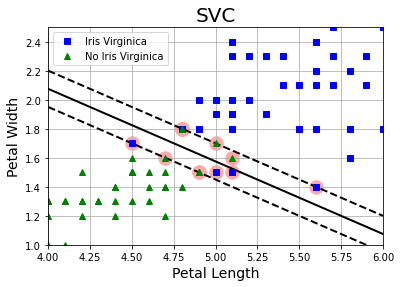

In [25]:
import matplotlib.pyplot as plt

plot_svc_decision_boundary(svm, 4, 6)
yr = y.ravel()
plt.plot(X[:,0][yr==1], X[:,1][yr==1], "bs", label='Iris Virginica')
plt.plot(X[:,0][yr==0], X[:,1][yr==0], "g^", label='No Iris Virginica')
plt.axis([4, 6, 1, 2.5])
plt.title("SVC", fontsize=20)
plt.legend()
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.grid()
plt.show()

Una manera de entrenar una SVM con descenso por gradiente es usar un [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgd#sklearn.linear_model.SGDClassifier) para minimizar la función de coste *hinge*.

\begin{equation}
  J(\mathbf{w}, b) = \frac{1}{2} \mathbf{w}^T \mathbf{w} + C \sum_{j=1}^N max(0, 1 - t^{(j)}(\mathbf{w}^T \mathbf{x}+b))
\end{equation}

In [26]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(alpha=0.017)
sgd.fit(X, yr)

SGDClassifier(alpha=0.017)

In [27]:
t = 2*y-1
w = np.r_[sgd.intercept_[0], sgd.coef_[0]]
X_b = np.c_[np.ones((len(X), 1)), X]
X_b_t = X_b * t
support_vectors_idx = (X_b_t.dot(w) < 1).ravel() 
sgd.support_vectors_ = X[support_vectors_idx]

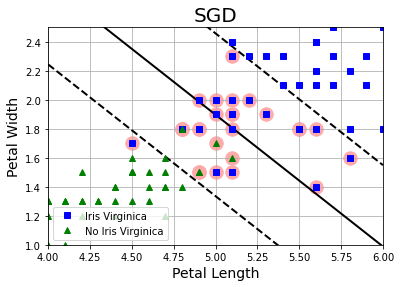

In [28]:
plot_svc_decision_boundary(sgd, 4, 6)
yr = y.ravel()
plt.plot(X[:,0][yr==1], X[:,1][yr==1], "bs", label='Iris Virginica')
plt.plot(X[:,0][yr==0], X[:,1][yr==0], "g^", label='No Iris Virginica')
plt.axis([4, 6, 1, 2.5])
plt.title("SGD", fontsize=20)
plt.legend()
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.grid()
plt.show()

Alternativamente, podemos implementar nuestra propia lógica de GD.

In [33]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta=0.1, epochs=1000):
        self.C = C
        self.eta = eta
        self.epochs = epochs

    def fit(self, X, y):
        # PASOS
        # 1 - Inicializar pesos aleatorios
        # 2 - Loop de entrenamiento
        #   2.1 - Calcular vectores soporte
        #   2.2 - Calcular función de pérdida
        #   2.3 - Calcular gradiente de función de pérdida con respecto a los parámteros
        #   2.4 - Actualizar parámetros
        # 3 - Guardar resultados

        w = np.random.randn(2, 1)
        b = 0
        t = 2*y-1
        X_t = X*t

        for e in range(1, self.epochs+1):

          support_vectors_idx = (X_t.dot(w) + t*b < 1).ravel()
          X_t_sv = X_t[support_vectors_idx]
          t_sv = t[support_vectors_idx]

          grad_w = w - self.C*np.sum(X_t_sv, axis=0).reshape(-1, 1)
          grad_b = - self.C * np.sum(t_sv)
          
          w = w - self.eta * grad_w
          b = b - self.eta * grad_b

        self.coef_ = np.array([w])
        self.intercept_ = np.array([b])
        support_vectors_idx = (X_t.dot(w) + t*b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]

In [34]:
myLinearSVC = MyLinearSVC(C=100, eta=0.0001, epochs=10000)
myLinearSVC.fit(X, y)

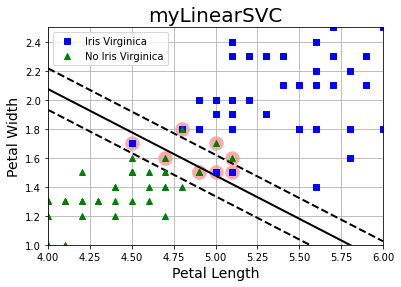

In [35]:
plot_svc_decision_boundary(myLinearSVC, 4, 6)
yr = y.ravel()
plt.plot(X[:,0][yr==1], X[:,1][yr==1], "bs", label='Iris Virginica')
plt.plot(X[:,0][yr==0], X[:,1][yr==0], "g^", label='No Iris Virginica')
plt.axis([4, 6, 1, 2.5])
plt.title("myLinearSVC", fontsize=20)
plt.legend()
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.grid()
plt.show()

In [36]:
myLinearSVC.intercept_[0], myLinearSVC.coef_[0]

(-31.169999999999117,
 array([[4.16760111],
        [6.99269871]]))

## Resumen

En este post hemos introducido el modelo de *Support Vector Machine*, el cual podemos usar para clasificación y regresión (incluso también detección de anomalías). Este modelo es una buena elección en el caso de no disponer de un gran dataset, ya que está totalmente determinado por unas pocas instancias (los vectores soporte). Además, gracias al *kernel trick*, permite trabajar con datasets que no sean linealmente separables. 